##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom training: walkthrough

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to train a machine learning model with a custom training loop to *categorize* penguins by species. In this notebook, you use TensorFlow to accomplish the following:

1. Import a dataset
2. Build a simple linear model
3. Train the model
4. Evaluate the model's effectiveness
5. Use the trained model to make predictions

## TensorFlow programming

This tutorial demonstrates the following TensorFlow programming tasks:

* Importing data with the [TensorFlow Datasets API](https://www.tensorflow.org/datasets/overview#load_a_dataset)
* Building models and layers with the [Keras API](https://www.tensorflow.org/guide/keras/)


## Penguin classification problem 

Imagine you are an ornithologist seeking an automated way to categorize each penguin you find. Machine learning provides many algorithms to classify penguins statistically. For instance, a sophisticated machine learning program could classify penguins based on photographs. The model you build in this tutorial is a little simpler. It classifies penguins based on their body weight, flipper length, and beaks, specifically the length and width measurements of their [culmen](https://en.wikipedia.org/wiki/Beak#Culmen).

There are 18 species of penguins, but in this tutorial you will only attempt to classify the following three:

* Chinstrap penguins
* Gentoo penguins
* Adélie penguins

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/tutorials/customization/images/penguins_ds_species.png" alt="Illustration of Chinstrap, Gentoo, and Adélie penguins"
     class="no-filter">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://en.wikipedia.org/wiki/Chinstrap_penguin">Chinstratp</a>, <a href="https://en.wikipedia.org/wiki/Gentoo_penguin">Gentoo</a>, and <a href="https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin">Adélie</a> penguins (Artwork by @allison_horst, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Fortunately, a research team has already created and shared a [dataset of 334 penguins](https://allisonhorst.github.io/palmerpenguins/) with body weight, flipper length, beak measurements, and other data. This dataset is also conveniently available as the [penguins](https://www.tensorflow.org/datasets/catalog/penguins) TensorFlow Dataset.  

## Setup

Install the `tfds-nightly` package for the penguins dataset. The `tfds-nightly` package is the nightly released version of the TensorFlow Datasets (TFDS). For more information on TFDS, see [TensorFlow Datasets overview](https://www.tensorflow.org/datasets/overview).

In [2]:
!pip install -q tfds-nightly

Then select **Runtime > Restart Runtime** from the Colab menu to restart the Colab runtime.

Do not proceed with the rest of this tutorial without first restarting the runtime.

Import TensorFlow and the other required Python modules. 

In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

2024-08-16 02:28:31.903728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 02:28:31.924949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 02:28:31.931168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.17.0
TensorFlow Datasets version:  4.9.3+nightly


## Import the dataset

The default [penguins/processed](https://www.tensorflow.org/datasets/catalog/penguins) TensorFlow Dataset is already cleaned, normalized, and ready for building a model. Before you download the processed data, preview a simplified version to get familiar with the original penguin survey data.


### Preview the data

Download the simplified version of the penguins dataset (`penguins/simple`) using the TensorFlow Datasets [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method. There are 344 data records in this dataset. Extract the first five records into a [`DataFrame`](https://www.tensorflow.org/datasets/api_docs/python/tfds/as_dataframe) object to inspect a sample of the values in this dataset:

In [4]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

I0000 00:00:1723775316.046133   60662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


I0000 00:00:1723775316.049924   60662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775316.053653   60662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775316.057338   60662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775316.068654   60662 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


2024-08-16 02:28:38.027706: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The numbered rows are data records, one _[example](https://developers.google.com/machine-learning/glossary/#example)_ per line, where:
  * The first six fields are _[features](https://developers.google.com/machine-learning/glossary/#feature)_: these are the characteristics of an example. Here, the fields hold numbers representing penguin measurements.
  * The last column is the _[label](https://developers.google.com/machine-learning/glossary/#label)_: this is the value you want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a penguin species name.

In the dataset, the label for the penguin species is represented as a number to make it easier to work with in the model you are building. These numbers correspond to the following penguin species:

* `0`: Adélie penguin
* `1`: Chinstrap penguin
* `2`: Gentoo penguin

Create a list containing the penguin species names in this order. You will use this list to interpret the output of the classification model:

In [5]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

For more information about features and labels, refer to the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

### Download the preprocessed dataset

Now, download the preprocessed penguins dataset (`penguins/processed`) with the `tfds.load` method, which returns a list of `tf.data.Dataset` objects. Note that the `penguins/processed` dataset doesn't come with its own test set, so use an 80:20 split to [slice the full dataset](https://www.tensorflow.org/datasets/splits) into the training and test sets. You will use the test dataset later to verify your model.

In [6]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.3559322, 0.41666666]        0


2024-08-16 02:28:39.105506: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-08-16 02:28:39.262195: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Notice that this version of the dataset has been processed by reducing the data down to four normalized features and a species label. In this format, the data can be quickly used to train a model without further processing.

In [7]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

2024-08-16 02:28:39.428348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


You can visualize some clusters by plotting a few features from the batch:

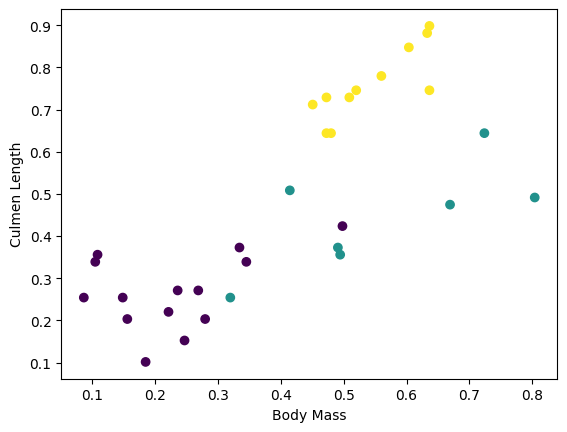

In [8]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

## Build a simple linear model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  For the penguin classification problem, the model defines the relationship between the body mass, flipper and culmen measurements and the predicted penguin species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the penguin species *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between body mass and culmen measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program figures out the relationships for you.

### Select the model

Next you need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the penguin classification problem. [*Neural networks*](https://developers.google.com/machine-learning/glossary/#neural_network) can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more [*hidden layers*](https://developers.google.com/machine-learning/glossary/#hidden_layer). Each hidden layer consists of one or more [*neurons*](https://developers.google.com/machine-learning/glossary/#neuron). There are several categories of neural networks and this program uses a dense, or [*fully-connected neural network*](https://developers.google.com/machine-learning/glossary/#fully_connected_layer): the neurons in one layer receive input connections from *every* neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:



<table>
  <tr><td>
    <img src="https://www.tensorflow.org/tutorials/customization/images/full_network_penguin.png" alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs"
     class="no-filter">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When you train the model from Figure 2 and feed it an unlabeled example, it yields three predictions: the likelihood that this penguin is the given penguin species. This prediction is called [*inference*](https://developers.google.com/machine-learning/crash-course/glossary#inference). For this example, the sum of the output predictions is 1.0. In Figure 2, this prediction breaks down as: `0.02` for *Adelie*, `0.95` for *Chinstrap*, and `0.03` for *Gentoo* species. This means that the model predicts—with 95% probability—that an unlabeled example penguin is a *Chinstrap* penguin.

### Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two `tf.keras.layers.Dense` layers with 10 nodes each, and an output layer with 3 nodes representing your label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required:

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The [*activation function*](https://developers.google.com/machine-learning/crash-course/glossary#activation_function) determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many `tf.keras.activations`, but [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

### Use the model

Let's have a quick look at what this model does to a batch of features:

In [10]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.01486555, -0.2774356 , -0.4446883 ],
       [-0.01989127, -0.18148412, -0.23701203],
       [-0.01520463, -0.38729626, -0.6065093 ],
       [-0.01831748, -0.22101548, -0.35036355],
       [-0.05447623, -0.24796928, -0.36515424]], dtype=float32)>

Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class.

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [11]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.41327488, 0.31783837, 0.26888674],
       [0.37655985, 0.32037243, 0.3030677 ],
       [0.44585222, 0.30732197, 0.24682581],
       [0.39463627, 0.32223028, 0.2831335 ],
       [0.39107943, 0.322279  , 0.2866416 ]], dtype=float32)>

Taking the `tf.math.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:

In [12]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


## Train the model

[*Training*](https://developers.google.com/machine-learning/crash-course/glossary#training) is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called [*overfitting*](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)—it's like memorizing the answers instead of understanding how to solve a problem.

The penguin classification problem is an example of [*supervised machine learning*](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning): the model is trained from examples that contain labels. In [*unsupervised machine learning*](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning), the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Define the loss and gradients function

Both training and evaluation stages need to calculate the model's [*loss*](https://developers.google.com/machine-learning/crash-course/glossary#loss). This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. You want to minimize, or optimize, this value.

Your model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.0923010110855103


Use the `tf.GradientTape` context to calculate the [*gradients*](https://developers.google.com/machine-learning/crash-course/glossary#gradient) used to optimize your model:

In [15]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

An [*optimizer*](https://developers.google.com/machine-learning/crash-course/glossary#optimizer) applies the computed gradients to the model's parameters to minimize the `loss` function. You can think of the loss function as a curved surface (refer to Figure 3) and you want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so you'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, you'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize the loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow has many optimization algorithms available for training. In this tutorial, you will use the `tf.keras.optimizers.SGD` that implements the [*stochastic gradient descent*](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent) (SGD) algorithm. The `learning_rate` parameter sets the step size to take for each iteration down the hill. This rate is a [*hyperparameter*](https://developers.google.com/machine-learning/glossary/#hyperparameter) that you'll commonly adjust to achieve better results.

Instantiate the optimizer with a [*learning rate*](https://developers.google.com/machine-learning/glossary#learning-rate) of `0.01`, a scalar value that is multiplied by the gradient at each iteration of the training:

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Then use this object to calculate a single optimization step:

In [17]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.0923010110855103
Step: 1,         Loss: 1.0911823511123657


### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's parameters.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. In the code below, `num_epochs` is set to 201 which means this training loop will run 201 times. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a [*hyperparameter*](https://developers.google.com/machine-learning/glossary/#hyperparameter) that you can tune. Choosing the right number usually requires both experience and experimentation:

In [18]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.082, Accuracy: 44.944%


Epoch 050: Loss: 0.738, Accuracy: 80.524%


Epoch 100: Loss: 0.377, Accuracy: 85.393%


Epoch 150: Loss: 0.236, Accuracy: 95.506%


Epoch 200: Loss: 0.164, Accuracy: 96.255%


Alternatively, you could use the built-in Keras [`Model.fit(ds_train_batch)`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method to train your model. 

### Visualize the loss function over time

While it's helpful to print out the model's training progress, you can visualize the progress with [TensorBoard](https://www.tensorflow.org/tensorboard) - a visualization and metrics tool that is packaged with TensorFlow. For this simple example, you will create basic charts using the `matplotlib` module.

Interpreting these charts takes some experience, but in general you want to see the *loss* decrease and the *accuracy* increase:

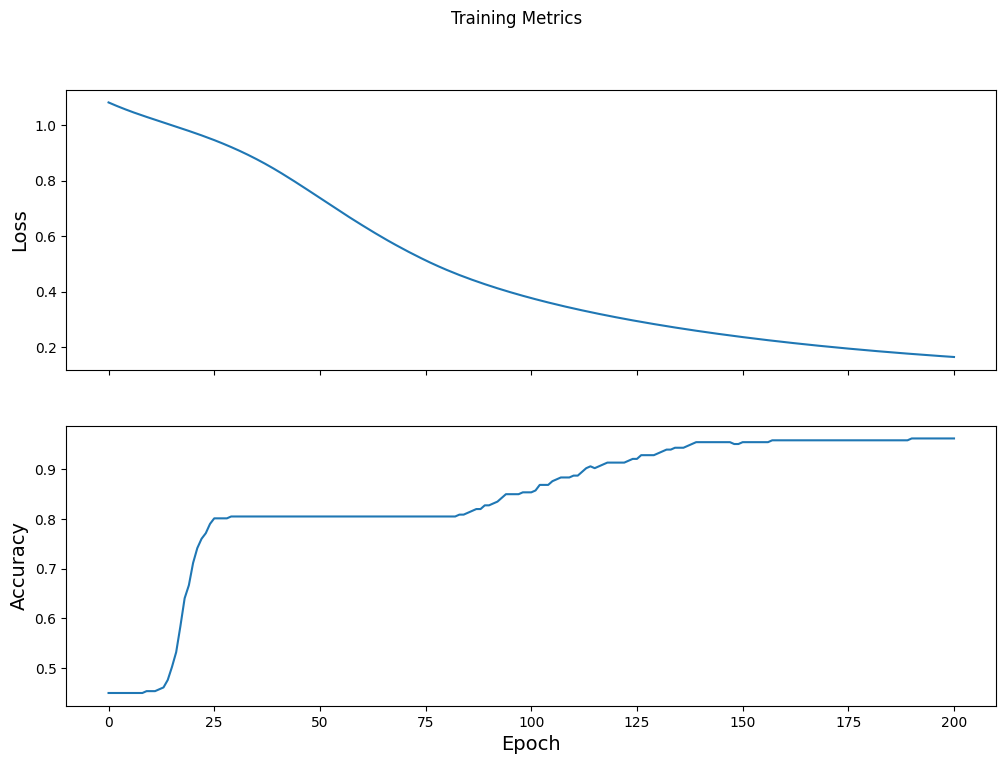

In [19]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate the model's effectiveness

Now that the model is trained, you can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at penguin classification, pass some measurements to the model and ask the model to predict what penguin species they represent. Then compare the model's predictions against the actual label.  For example, a model that picked the correct species on half the input examples has an [*accuracy*](https://developers.google.com/machine-learning/glossary/#accuracy) of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> A penguin classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Set up the test set

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The penguin dataset doesn't have a separate test dataset so in the previous Download the dataset section, you split the original dataset into test and train datasets. Use the `ds_test_batch` dataset for the evaluation.

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. The following code iterates over each example in the test set and compare the model's prediction against the actual label. This comparison is used to measure the model's accuracy across the entire test set:

In [20]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 97.015%


You can also use the `model.evaluate(ds_test, return_dict=True)` keras function to get accuracy information on your test dataset. 

By inspecting the last batch, for example, you can observe that the model predictions are usually correct.


In [21]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]])>

## Use the trained model to make predictions

You've trained a model and "proven" that it's good—but not perfect—at classifying penguin species. Now let's use the trained model to make some predictions on [*unlabeled examples*](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not labels.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For this tutorial, manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Adélie penguin
* `1`: Chinstrap penguin
* `2`: Gentoo penguin

In [22]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (90.4%)
Example 1 prediction: Gentoo (96.0%)
Example 2 prediction: Chinstrap (84.3%)
